# **Lab: Logistic Regression for Gene Expression Data**

Using logistic regression to predict biological characteristics, i.e. "phenotypes" from gene expression data.


Loading modules and data

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import linear_model, preprocessing

In [2]:
df = pd.read_excel("https://archive.ics.uci.edu/ml/machine-learning-databases/00342/Data_Cortex_Nuclear.xls", index_col=0)
df.head()

,DYRK1A_N,ITSN1_N,BDNF_N,NR1_N,NR2A_N,pAKT_N,pBRAF_N,pCAMKII_N,pCREB_N,pELK_N,pERK_N,pJNK_N,PKCA_N,pMEK_N,pNR1_N,pNR2A_N,pNR2B_N,pPKCAB_N,pRSK_N,AKT_N,BRAF_N,CAMKII_N,CREB_N,ELK_N,ERK_N,GSK3B_N,JNK_N,MEK_N,TRKA_N,RSK_N,APP_N,Bcatenin_N,SOD1_N,MTOR_N,P38_N,pMTOR_N,DSCR1_N,AMPKA_N,NR2B_N,pNUMB_N,...,TIAM1_N,pP70S6_N,NUMB_N,P70S6_N,pGSK3B_N,pPKCG_N,CDK5_N,S6_N,ADARB1_N,AcetylH3K9_N,RRP1_N,BAX_N,ARC_N,ERBB4_N,nNOS_N,Tau_N,GFAP_N,GluR3_N,GluR4_N,IL1B_N,P3525_N,pCASP9_N,PSD95_N,SNCA_N,Ubiquitin_N,pGSK3B_Tyr216_N,SHH_N,BAD_N,BCL2_N,pS6_N,pCFOS_N,SYP_N,H3AcK18_N,EGR1_N,H3MeK4_N,CaNA_N,Genotype,Treatment,Behavior,class
MouseID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
309_1,0.503644,0.747193,0.430175,2.816329,5.990152,0.218830,0.177565,2.373744,0.232224,1.750936,0.687906,0.306382,0.402698,0.296927,1.022060,0.605673,1.877684,2.308745,0.441599,0.859366,0.416289,0.369608,0.178944,1.866358,3.685247,1.537227,0.264526,0.319677,0.813866,0.165846,0.453910,3.037621,0.369510,0.458539,0.335336,0.825192,0.576916,0.448099,0.586271,0.394721,...,0.482864,0.294170,0.182150,0.842725,0.192608,1.443091,0.294700,0.354605,1.339070,0.170119,0.159102,0.188852,0.106305,0.144989,0.176668,0.125190,0.115291,0.228043,0.142756,0.430957,0.247538,1.603310,2.014875,0.108234,1.044979,0.831557,0.188852,0.122652,NaN,0.106305,0.108336,0.427099,0.114783,0.131790,0.128186,1.675652,Control,Memantine,C/S,c-CS-m
309_2,0.514617,0.689064,0.411770,2.789514,5.685038,0.211636,0.172817,2.292150,0.226972,1.596377,0.695006,0.299051,0.385987,0.281319,0.956676,0.587559,1.725774,2.043037,0.445222,0.834659,0.400364,0.356178,0.173680,1.761047,3.485287,1.509249,0.255727,0.304419,0.780504,0.157194,0.430940,2.921882,0.342279,0.423560,0.324835,0.761718,0.545097,0.420876,0.545097,0.368255,...,0.454519,0.276431,0.182086,0.847615,0.194815,1.439460,0.294060,0.354548,1.306323,0.171427,0.158129,0.184570,0.106592,0.150471,0.178309,0.134275,0.118235,0.238073,0.142037,0.457156,0.257632,1.671738,2.004605,0.109749,1.009883,0.849270,0.200404,0.116682,NaN,0.106592,0.104315,0.441581,0.111974,0.135103,0.131119,1.743610,Control,Memantine,C/S,c-CS-m
309_3,0.509183,0.730247,0.418309,2.687201,5.622059,0.209011,0.175722,2.283337,0.230247,1.561316,0.677348,0.291276,0.381002,0.281710,1.003635,0.602449,1.731873,2.017984,0.467668,0.814329,0.399847,0.368089,0.173905,1.765544,3.571456,1.501244,0.259614,0.311747,0.785154,0.160895,0.423187,2.944136,0.343696,0.425005,0.324852,0.757031,0.543620,0.404630,0.552994,0.363880,...,0.447197,0.256648,0.184388,0.856166,0.200737,1.524364,0.301881,0.386087,1.279600,0.185456,0.148696,0.190532,0.108303,0.145330,0.176213,0.132560,0.117760,0.244817,0.142445,0.510472,0.255343,1.663550,2.016831,0.108196,0.996848,0.846709,0.193685,0.118508,NaN,0.108303,0.106219,0.435777,0.111883,0.133362,0.127431,1.926427,Control,Memantine,C/S,c-CS-m
309_4,0.442107,0.617076,0.358626,2.466947,4.979503,0.222886,0.176463,2.152301,0.207004,1.595086,0.583277,0.296729,0.377087,0.313832,0.875390,0.520293,1.566852,2.132754,0.477671,0.727705,0.385639,0.362970,0.179449,1.286277,2.970137,1.419710,0.259536,0.279218,0.734492,0.162210,0.410615,2.500204,0.344509,0.429211,0.330121,0.746980,0.546763,0.386860,0.547849,0.366771,...,0.442650,0.398534,0.161768,0.760234,0.184169,1.612382,0.296382,0.290680,1.198765,0.159799,0.166112,0.185323,0.103184,0.140656,0.163804,0.123210,0.117439,0.234947,0.145068,0.430996,0.251103,1.484624,1.957233,0.119883,0.990225,0.833277,0.192112,0.132781,NaN,0.103184,0.111262,0.391691,0.130405,0.147444,0.146901,1.700563,Control,Memantine,C/S,c-CS-m
309_5,0.434940,0.617430,0.358802,2.365785,4.718679,0.213106,0.173627,2.134014,0.192158,1.504230,0.550960,0.286961,0.363502,0.277964,0.864912,0.507990,1.480059,2.013697,0.483416,0.687794,0.367531,0.355311,0.174836,1.324695,2.896334,1.359876,0.250705,0.273667,0.702699,0.154827,0.398550,2.456560,0.329126,0.408755,0.313415,0.691956,0.536860,0.360816,0.512824,0.351551,...,0.419095,0.393447,0.160200,0.768113,0.185718,1.6458

Replacing missing values by mean value of each column

In [3]:
df1 = df.where(pd.notna(df), df.mean(), axis='columns')
xnames = df1.columns
df1.head()

,DYRK1A_N,ITSN1_N,BDNF_N,NR1_N,NR2A_N,pAKT_N,pBRAF_N,pCAMKII_N,pCREB_N,pELK_N,pERK_N,pJNK_N,PKCA_N,pMEK_N,pNR1_N,pNR2A_N,pNR2B_N,pPKCAB_N,pRSK_N,AKT_N,BRAF_N,CAMKII_N,CREB_N,ELK_N,ERK_N,GSK3B_N,JNK_N,MEK_N,TRKA_N,RSK_N,APP_N,Bcatenin_N,SOD1_N,MTOR_N,P38_N,pMTOR_N,DSCR1_N,AMPKA_N,NR2B_N,pNUMB_N,...,TIAM1_N,pP70S6_N,NUMB_N,P70S6_N,pGSK3B_N,pPKCG_N,CDK5_N,S6_N,ADARB1_N,AcetylH3K9_N,RRP1_N,BAX_N,ARC_N,ERBB4_N,nNOS_N,Tau_N,GFAP_N,GluR3_N,GluR4_N,IL1B_N,P3525_N,pCASP9_N,PSD95_N,SNCA_N,Ubiquitin_N,pGSK3B_Tyr216_N,SHH_N,BAD_N,BCL2_N,pS6_N,pCFOS_N,SYP_N,H3AcK18_N,EGR1_N,H3MeK4_N,CaNA_N,Genotype,Treatment,Behavior,class
MouseID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
309_1,0.503644,0.747193,0.430175,2.816329,5.990152,0.218830,0.177565,2.373744,0.232224,1.750936,0.687906,0.306382,0.402698,0.296927,1.022060,0.605673,1.877684,2.308745,0.441599,0.859366,0.416289,0.369608,0.178944,1.866358,3.685247,1.537227,0.264526,0.319677,0.813866,0.165846,0.453910,3.037621,0.369510,0.458539,0.335336,0.825192,0.576916,0.448099,0.586271,0.394721,...,0.482864,0.294170,0.182150,0.842725,0.192608,1.443091,0.294700,0.354605,1.339070,0.170119,0.159102,0.188852,0.106305,0.144989,0.176668,0.125190,0.115291,0.228043,0.142756,0.430957,0.247538,1.603310,2.014875,0.108234,1.044979,0.831557,0.188852,0.122652,0.134762,0.106305,0.108336,0.427099,0.114783,0.131790,0.128186,1.675652,Control,Memantine,C/S,c-CS-m
309_2,0.514617,0.689064,0.411770,2.789514,5.685038,0.211636,0.172817,2.292150,0.226972,1.596377,0.695006,0.299051,0.385987,0.281319,0.956676,0.587559,1.725774,2.043037,0.445222,0.834659,0.400364,0.356178,0.173680,1.761047,3.485287,1.509249,0.255727,0.304419,0.780504,0.157194,0.430940,2.921882,0.342279,0.423560,0.324835,0.761718,0.545097,0.420876,0.545097,0.368255,...,0.454519,0.276431,0.182086,0.847615,0.194815,1.439460,0.294060,0.354548,1.306323,0.171427,0.158129,0.184570,0.106592,0.150471,0.178309,0.134275,0.118235,0.238073,0.142037,0.457156,0.257632,1.671738,2.004605,0.109749,1.009883,0.849270,0.200404,0.116682,0.134762,0.106592,0.104315,0.441581,0.111974,0.135103,0.131119,1.743610,Control,Memantine,C/S,c-CS-m
309_3,0.509183,0.730247,0.418309,2.687201,5.622059,0.209011,0.175722,2.283337,0.230247,1.561316,0.677348,0.291276,0.381002,0.281710,1.003635,0.602449,1.731873,2.017984,0.467668,0.814329,0.399847,0.368089,0.173905,1.765544,3.571456,1.501244,0.259614,0.311747,0.785154,0.160895,0.423187,2.944136,0.343696,0.425005,0.324852,0.757031,0.543620,0.404630,0.552994,0.363880,...,0.447197,0.256648,0.184388,0.856166,0.200737,1.524364,0.301881,0.386087,1.279600,0.185456,0.148696,0.190532,0.108303,0.145330,0.176213,0.132560,0.117760,0.244817,0.142445,0.510472,0.255343,1.663550,2.016831,0.108196,0.996848,0.846709,0.193685,0.118508,0.134762,0.108303,0.106219,0.435777,0.111883,0.133362,0.127431,1.926427,Control,Memantine,C/S,c-CS-m
309_4,0.442107,0.617076,0.358626,2.466947,4.979503,0.222886,0.176463,2.152301,0.207004,1.595086,0.583277,0.296729,0.377087,0.313832,0.875390,0.520293,1.566852,2.132754,0.477671,0.727705,0.385639,0.362970,0.179449,1.286277,2.970137,1.419710,0.259536,0.279218,0.734492,0.162210,0.410615,2.500204,0.344509,0.429211,0.330121,0.746980,0.546763,0.386860,0.547849,0.366771,...,0.442650,0.398534,0.161768,0.760234,0.184169,1.612382,0.296382,0.290680,1.198765,0.159799,0.166112,0.185323,0.103184,0.140656,0.163804,0.123210,0.117439,0.234947,0.145068,0.430996,0.251103,1.484624,1.957233,0.119883,0.990225,0.833277,0.192112,0.132781,0.134762,0.103184,0.111262,0.391691,0.130405,0.147444,0.146901,1.700563,Control,Memantine,C/S,c-CS-m
309_5,0.434940,0.617430,0.358802,2.365785,4.718679,0.213106,0.173627,2.134014,0.192158,1.504230,0.550960,0.286961,0.363502,0.277964,0.864912,0.507990,1.480059,2.013697,0.483416,0.687794,0.367531,0.355311,0.174836,1.324695,2.896334,1.359876,0.250705,0.273667,0.702699,0.154827,0.398550,2.456560,0.329126,0.408755,0.313415,0.691956,0.536860,0.360816,0.512824,0.351551,...,0.419095,0.393447,0.160200,0.76

**Binary Classification for Down's Syndrome**

Getting numeric vector y indicating binary values of column "Genotype"

In [4]:
yraw, y = np.unique(df1['Genotype'].values, return_inverse=True)

Getting data from dataframe

In [5]:
X = np.array(df1.iloc[:,:-4]) 
X.shape

(1080, 77)

Splitting training and test data

In [6]:
from sklearn.model_selection import train_test_split

Xtr, Xts, ytr, yts = train_test_split(X,y, test_size=0.30)

Scaling the data using standard scaler

In [7]:
from sklearn.preprocessing import StandardScaler

scal = StandardScaler()
Xtr1 = scal.fit_transform(Xtr)
Xts1 = scal.transform(Xts)

Fitting logistic regression model on scaled training data

In [8]:
logreg = linear_model.LogisticRegression(C=1e5, solver='liblinear')
logreg.fit(Xtr1, ytr)

LogisticRegression(C=100000.0, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

Measuring classifier accuracy on test data

In [9]:
yhat = logreg.predict(Xts1)
acc = np.mean(yhat == yts)
print("Accuracy on test data = %f" % acc)

Accuracy on test data = 0.956790


Interpreting the weight vector

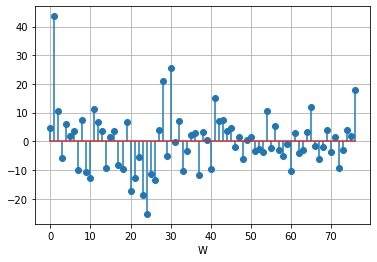

In [10]:
W = np.reshape(logreg.coef_, newshape=-1)
plt.stem(W, use_line_collection=True)
plt.xlabel("W")
plt.grid()

Finding names of the genes fir two components i where magnitude W[i] is largest

In [11]:
max = np.argsort(np.abs(W))
for i in range(2):
  j = max[i]
  print('%10s %12f' % (xnames[j], W[j]) )

Bcatenin_N    -0.064798
   pNUMB_N     0.308392


**Cross Validation**

Performing 10-fold cross validation to obtain slightly better result

In [12]:
from sklearn.model_selection import KFold
from sklearn.metrics import precision_recall_fscore_support
nfold = 10
kf = KFold(n_splits=nfold, shuffle=True)
acc = np.zeros(nfold)
prec = np.zeros(nfold)
rec = np.zeros(nfold)
f1 = np.zeros(nfold)

for i, I in enumerate(kf.split(X)):
    
    # Get training and test data
    train, test = I
    Xtr = X[train,:]
    ytr = y[train]
    Xts = X[test,:]
    yts = y[test]
    
    # Scale the data
    scal = StandardScaler()
    Xtr1 = scal.fit_transform(Xtr)
    Xts1 = scal.transform(Xts)    
    
    # Fit a model    
    logreg.fit(Xtr1, ytr)
    
    # Predict on test samples and measure accuracy
    yhat = logreg.predict(Xts1)
    acc[i] = np.mean(yhat == yts)
    
    # Measure other performance metrics
    prec[i],rec[i],f1[i],_  = precision_recall_fscore_support(yts,yhat,average='binary') 
    

# Take average values of the metrics
precm = np.mean(prec)
recm = np.mean(rec)
f1m = np.mean(f1)
accm= np.mean(acc)

# Compute the standard errors
prec_se = np.std(prec)/np.sqrt(nfold-1)
rec_se = np.std(rec)/np.sqrt(nfold-1)
f1_se = np.std(f1)/np.sqrt(nfold-1)
acc_se = np.std(acc)/np.sqrt(nfold-1)

print('Precision = {0:.4f}, SE={1:.4f}'.format(precm,prec_se))
print('Recall =    {0:.4f}, SE={1:.4f}'.format(recm, rec_se))
print('f1 =        {0:.4f}, SE={1:.4f}'.format(f1m, f1_se))
print('Accuracy =  {0:.4f}, SE={1:.4f}'.format(accm, acc_se))

Precision = 0.9530, SE=0.0094
Recall =    0.9621, SE=0.0092
f1 =        0.9571, SE=0.0060
Accuracy =  0.9593, SE=0.0059


**Multi Class Classification**

Using df1['class'] which has 8 possible classes.

In [13]:
yraw, y1 = np.unique(df1['class'].values, return_inverse=True)
Xtr, Xts, ytr, yts = train_test_split(X, y1, test_size=0.30)

scal = StandardScaler()
Xtr1 = scal.fit_transform(Xtr)
Xts1 = scal.transform(Xts)

logreg1 = linear_model.LogisticRegression(C=1e5, solver='liblinear')
logreg1.fit(Xtr1, ytr)

LogisticRegression(C=100000.0, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [14]:
from sklearn.metrics import confusion_matrix

nfold = 10
kf = KFold(n_splits=nfold, shuffle=True)
acc = np.zeros(nfold)
prec = np.zeros(nfold)
rec = np.zeros(nfold)
f1 = np.zeros(nfold)
C = np.zeros((8,8))

for i, I in enumerate(kf.split(X)):
    
    # Get training and test data
    train, test = I
    Xtr = X[train,:]
    ytr = y1[train]
    Xts = X[test,:]
    yts = y1[test]
    
    # Scale the data
    scal = StandardScaler()
    Xtr1 = scal.fit_transform(Xtr)
    Xts1 = scal.transform(Xts)    
    
    # Fit a model    
    logreg.fit(Xtr1, ytr)
    
    # Predict on test samples and measure accuracy
    yhat = logreg.predict(Xts1)
    acc[i] = np.mean(yhat == yts)
    C += confusion_matrix(yts,yhat,labels=np.unique(y1))

    # Measure other performance metrics
    prec[i],rec[i],f1[i],_  = precision_recall_fscore_support(yts,yhat, average='macro') 
    

# Take average values of the metrics
precm = np.mean(prec)
recm = np.mean(rec)
f1m = np.mean(f1)
accm= np.mean(acc)

# Compute the standard errors
prec_se = np.std(prec)/np.sqrt(nfold-1)
rec_se = np.std(rec)/np.sqrt(nfold-1)
f1_se = np.std(f1)/np.sqrt(nfold-1)
acc_se = np.std(acc)/np.sqrt(nfold-1)

print('Precision = {0:.4f}, SE={1:.4f}'.format(precm,prec_se))
print('Recall =    {0:.4f}, SE={1:.4f}'.format(recm, rec_se))
print('f1 =        {0:.4f}, SE={1:.4f}'.format(f1m, f1_se))
print('Accuracy =  {0:.4f}, SE={1:.4f}'.format(accm, acc_se))


Precision = 0.9863, SE=0.0029
Recall =    0.9855, SE=0.0031
f1 =        0.9853, SE=0.0031
Accuracy =  0.9861, SE=0.0028


In [15]:
for i in range(8):
  C[i]=C[i]/np.sum(C[i])
print(np.array_str(C, precision=4, suppress_small=True))

[[0.9667 0.0133 0.0067 0.     0.0067 0.0067 0.     0.    ]
 [0.0148 0.9778 0.     0.     0.0074 0.     0.     0.    ]
 [0.     0.0133 0.98   0.     0.     0.     0.     0.0067]
 [0.0074 0.     0.     0.9852 0.0074 0.     0.     0.    ]
 [0.     0.     0.     0.     1.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.     1.     0.     0.    ]
 [0.     0.0074 0.     0.0074 0.     0.     0.9852 0.    ]
 [0.     0.     0.     0.     0.     0.     0.     1.    ]]


Re-running logistic regression on the entire training data to get weight coefficients

In [16]:
scal = StandardScaler()
Xtr1 = scal.fit_transform(X)
logreg = linear_model.LogisticRegression(C=1e5, solver='liblinear')
logreg.fit(Xtr1, y1)

LogisticRegression(C=100000.0, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

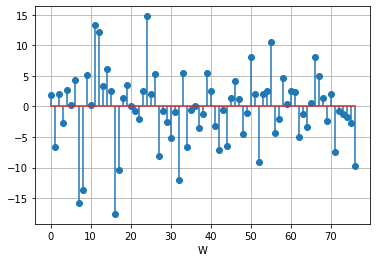

In [17]:
W = logreg.coef_[0,:]
plt.stem(W, use_line_collection=True)
plt.xlabel("W")
plt.grid()

Bonus Section: L1 Regularization

In [20]:
from sklearn.model_selection import KFold
nfold = 10
kf =KFold(nfold, shuffle=True)

alphas = np.logspace(-0.005,10,20)
nalpha = len(alphas)

In [21]:
nfold = 10
kf = KFold(n_splits=nfold, shuffle=True)
nalpha = len(alphas)
acc = np.zeros((nfold, nalpha))
prec = np.zeros((nfold,nalpha))
rec = np.zeros((nfold, nalpha))
f1 = np.zeros((nfold, nalpha))

for ifold, ind in enumerate(kf.split(X)):
        
    # Get the training data in the split
    Itr,Its = ind
    Xtr = X[Itr,:]
    ytr = y1[Itr]
    Xts = X[Its,:]
    yts = y1[Its]
    
    # Fit and transform the data
    xscal = StandardScaler()
    Xtr1 = xscal.fit_transform(Xtr)
    Xts1 = xscal.transform(Xts)

    for i, alpha in enumerate(alphas):

        # Fit on the training data
        reg = linear_model.LogisticRegression(penalty='l1', C=alpha, solver='liblinear')
        reg.fit(Xtr1, ytr)

        # Score on the test data
        yhat1 = reg.predict(Xts1)
        
        acc[ifold][i] = np.mean(yhat == yts)
        prec[ifold][i],rec[ifold][i],f1[ifold][i],_  = precision_recall_fscore_support(yts,yhat, average='macro')
    
    print('Fold = %d' % ifold)
    precm = np.mean(prec[ifold])
    recm = np.mean(rec[ifold])
    f1m = np.mean(f1[ifold])
    accm= np.mean(acc[ifold])

    prec_se = np.std(prec)/np.sqrt(nfold-1)
    rec_se = np.std(rec)/np.sqrt(nfold-1)
    f1_se = np.std(f1)/np.sqrt(nfold-1)
    acc_se = np.std(acc)/np.sqrt(nfold-1)

    print('Precision = {0:.4f}, SE={1:.4f}'.format(precm,prec_se))  
    print('Recall =    {0:.4f}, SE={1:.4f}'.format(recm, rec_se))
    print('f1 =        {0:.4f}, SE={1:.4f}'.format(f1m, f1_se))
    print('Accuracy =  {0:.4f}, SE={1:.4f}'.format(accm, acc_se))

Fold = 0
Precision = 0.6766, SE=0.0677
Recall =    0.6449, SE=0.0645
f1 =        0.6293, SE=0.0629
Accuracy =  0.6296, SE=0.0630
Fold = 1
Precision = 0.6561, SE=0.0889
Recall =    0.6360, SE=0.0854
f1 =        0.6160, SE=0.0830
Accuracy =  0.6296, SE=0.0840
Fold = 2
Precision = 0.5895, SE=0.0981
Recall =    0.5886, SE=0.0953
f1 =        0.5674, SE=0.0924
Accuracy =  0.6204, SE=0.0957
Fold = 3
Precision = 0.6808, SE=0.1065
Recall =    0.6643, SE=0.1036
f1 =        0.6382, SE=0.1002
Accuracy =  0.6296, SE=0.1024
Fold = 4
Precision = 0.4925, SE=0.1045
Recall =    0.5017, SE=0.1021
f1 =        0.4760, SE=0.0986
Accuracy =  0.4815, SE=0.1006
Fold = 5
Precision = 0.8107, SE=0.1092
Recall =    0.8338, SE=0.1084
f1 =        0.8031, SE=0.1046
Accuracy =  0.8148, SE=0.1065
Fold = 6
Precision = 0.6671, SE=0.1029
Recall =    0.6601, SE=0.1022
f1 =        0.6188, SE=0.0982
Accuracy =  0.6296, SE=0.1000
Fold = 7
Precision = 0.8093, SE=0.0944
Recall =    0.7789, SE=0.0931
f1 =        0.7719, SE=0.090